#### This notebook goes through the steps of doing an overlay of NDVI (Normalized Difference Vegetation Index) in conjuction with pulling records from GBIF

#### Step One: Import the Necessary Libraries and Initialize the Google Earth Engine API

In [77]:
import ee

ee.Authenticate()

ee.Initialize(project='ee-krle4401')



In [78]:
from pygbif import occurrences as gbif_occ
import geopandas as gpd
import folium
from shapely.geometry import Point


##### Step 2: Fetch Some LandSat Imagery

In [79]:
# Define NDVI calculation
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .map(lambda img: img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI'))  # Corrected band names

# Get median NDVI for the specified time period
median_ndvi = landsat.median().clip(roi)


#### Step 3: Fetch vegetation observations from GBIF

In [85]:
# Fetch GBIF occurrences for vegetation within the ROI
geometry = "POLYGON((-123.5 37.0, -121.5 37.0, -121.5 38.0, -123.5 38.0, -123.5 37.0))"  # Example geometry
taxon_key = 6  # Plants (example taxon key)
occurrences = gbif_occ.search(
    taxonKey=taxon_key,
    hasCoordinate=True,
    geometry=geometry,
    year=2020,  # Example year
    limit=300
)

# Convert GBIF data to a GeoDataFrame
records = [
    {
        "species": occ.get("species", "Unknown"),
        "latitude": occ["decimalLatitude"],
        "longitude": occ["decimalLongitude"]
    }
    for occ in occurrences["results"]
]

# Create GeoDataFrame with geometry
gdf = gpd.GeoDataFrame(records, geometry=[Point(xy) for xy in zip(
    [r["longitude"] for r in records],
    [r["latitude"] for r in records]
)])
print(gdf.head())  # Confirm `gdf` contains data
print(len(gdf))

                 species   latitude   longitude                     geometry
0          Pinus radiata  37.820328 -122.529858  POINT (-122.52986 37.82033)
1        Ribes malvaceum  37.903738 -121.928182  POINT (-121.92818 37.90374)
2  Arctostaphylos glauca  37.920340 -121.941526  POINT (-121.94153 37.92034)
3       Hedwigia ciliata  37.953533 -121.868172  POINT (-121.86817 37.95353)
4  Polytrichum piliferum  37.953525 -121.868080  POINT (-121.86808 37.95352)
300


#### Step 4: Overlay GBIF Vegetation on the NDVI layer

In [86]:
# Add an ID to each row
gdf['id'] = gdf.index

# Create GEE FeatureCollection with IDs
gbif_points = ee.FeatureCollection([
    ee.Feature(
        ee.Geometry.Point(row.geometry.x, row.geometry.y),
        {'id': row['id']}
    )
    for _, row in gdf.iterrows()
])

#### Step 5: Extract NDVI Values at GBIF Locations

In [87]:
# Sample NDVI values
samples = median_ndvi.sampleRegions(
    collection=gbif_points,
    scale=30
).getInfo()

# Extract NDVI values and map them to GeoDataFrame
ndvi_results = {feature['properties']['id']: feature['properties'].get('NDVI', float('nan'))
                for feature in samples['features']}
gdf['NDVI'] = gdf['id'].map(ndvi_results)

# Handle missing NDVI values
gdf['NDVI'] = gdf['NDVI'].fillna(float('nan'))  # Or replace with 0 if preferred

print(gdf)

                          species   latitude   longitude  \
0                   Pinus radiata  37.820328 -122.529858   
1                 Ribes malvaceum  37.903738 -121.928182   
2           Arctostaphylos glauca  37.920340 -121.941526   
3                Hedwigia ciliata  37.953533 -121.868172   
4           Polytrichum piliferum  37.953525 -121.868080   
..                            ...        ...         ...   
295              Raphanus sativus  37.788034 -122.472284   
296             Arbutus menziesii  37.402229 -122.335783   
297      Pentagramma triangularis  37.404128 -122.331881   
298         Epipactis helleborine  37.402146 -122.334661   
299  Notholithocarpus densiflorus  37.402233 -122.333960   

                        geometry   id      NDVI  
0    POINT (-122.52986 37.82033)    0  0.149221  
1    POINT (-121.92818 37.90374)    1  0.173772  
2    POINT (-121.94153 37.92034)    2  0.107101  
3    POINT (-121.86817 37.95353)    3  0.196375  
4    POINT (-121.86808 37.953

#### Step 6: Analyze and Visualize Results

In [91]:
# Import Folium for visualization
import folium

# Create a Folium map centered on the ROI
m = folium.Map(location=[37.5, -122], zoom_start=8)

# Add NDVI layer
ndvi_params = {'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}
map_id = median_ndvi.getMapId(ndvi_params)
folium.TileLayer(
    tiles=map_id['tile_fetcher'].url_format,
    attr="Google Earth Engine",
    name="NDVI",
    overlay=True
).add_to(m)

# Add GBIF observation points
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"{row['species']} - NDVI: {row['NDVI']:.2f}",
        icon=folium.Icon(color="green")
    ).add_to(m)

# Display the map
m


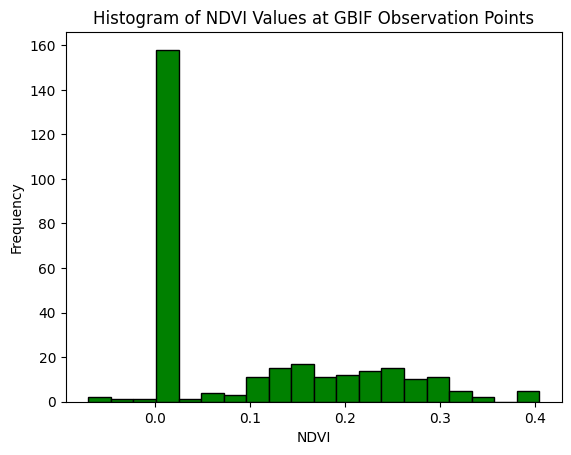

In [89]:
import matplotlib.pyplot as plt

# Plot histogram of NDVI values
plt.hist(gdf['NDVI'], bins=20, color='green', edgecolor='black')
plt.title("Histogram of NDVI Values at GBIF Observation Points")
plt.xlabel("NDVI")
plt.ylabel("Frequency")
plt.show()


In [90]:
# Summarize NDVI values
print("Summary Statistics for NDVI:")
print(gdf['NDVI'].describe())


Summary Statistics for NDVI:
count    298.000000
mean       0.098948
std        0.111871
min       -0.070561
25%        0.010902
50%        0.010902
75%        0.188836
max        0.404527
Name: NDVI, dtype: float64
